# Predictors of Pregnancy Risks

In [52]:
# Dependencies and Setup
%matplotlib inline

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress, pearsonr
import numpy as np

In [53]:
# Specifying path to CSV file
file_path = 'C:\\Users\\lnata\\GitHub\\Project1group3\\Resources\\maternal_health.csv'

# Read the .csv file
maternal_health = pd.read_csv(file_path)

In [54]:
# Print DataFrame
maternal_health.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [55]:
# Adding a new column 'Woman_ID' with unique identifiers starting from 1
maternal_health['Woman_ID'] = range(1, len(maternal_health) + 1)

# Reordering the DataFrame columns
columns = ['Woman_ID'] + [col for col in maternal_health.columns if col != 'Woman_ID']
maternal_health = maternal_health[columns]

# Print
maternal_health.head()

,Woman_ID,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,1,25,130,80,15.0,98.0,86,high risk
1,2,35,140,90,13.0,98.0,70,high risk
2,3,29,90,70,8.0,100.0,80,high risk
3,4,30,140,85,7.0,98.0,70,high risk
4,5,35,120,60,6.1,98.0,76,low risk


In [56]:
# Renaming columns for better understanding
maternal_renamed = maternal_health.rename(columns={"Woman_ID":"Woman ID", "BS":"Blood Sugar", "SystolicBP":"Systolic Blood Pressure", 
                                                   "DiastolicBP":"Diastolic Blood Pressure", "BodyTemp":"Body Temp.", 
                                                   "HeartRate":"Heart Rate", "RiskLevel":"Risk Level"})
maternal_renamed.head()

,Woman ID,Age,Systolic Blood Pressure,Diastolic Blood Pressure,Blood Sugar,Body Temp.,Heart Rate,Risk Level
0,1,25,130,80,15.0,98.0,86,high risk
1,2,35,140,90,13.0,98.0,70,high risk
2,3,29,90,70,8.0,100.0,80,high risk
3,4,30,140,85,7.0,98.0,70,high risk
4,5,35,120,60,6.1,98.0,76,low risk


In [57]:
# Create a new column "Blood Pressure" by combining "Systolic Blood Pressure" and "Diastolic Blood Pressure"
maternal_renamed.loc[:, 'Blood Pressure'] = maternal_renamed['Systolic Blood Pressure'].astype(str) + '/' + maternal_renamed['Diastolic Blood Pressure'].astype(str)
column_to_move = maternal_renamed.pop('Blood Pressure')
maternal_renamed.insert(4, 'Blood Pressure', column_to_move)

# Print
maternal_renamed.head()

,Woman ID,Age,Systolic Blood Pressure,Diastolic Blood Pressure,Blood Pressure,Blood Sugar,Body Temp.,Heart Rate,Risk Level
0,1,25,130,80,130/80,15.0,98.0,86,high risk
1,2,35,140,90,140/90,13.0,98.0,70,high risk
2,3,29,90,70,90/70,8.0,100.0,80,high risk
3,4,30,140,85,140/85,7.0,98.0,70,high risk
4,5,35,120,60,120/60,6.1,98.0,76,low risk


In [58]:
# Dropping duplicate data
maternal_df = maternal_renamed.drop_duplicates(subset=None, keep='first', inplace=False)
maternal_df.head()

,Woman ID,Age,Systolic Blood Pressure,Diastolic Blood Pressure,Blood Pressure,Blood Sugar,Body Temp.,Heart Rate,Risk Level
0,1,25,130,80,130/80,15.0,98.0,86,high risk
1,2,35,140,90,140/90,13.0,98.0,70,high risk
2,3,29,90,70,90/70,8.0,100.0,80,high risk
3,4,30,140,85,140/85,7.0,98.0,70,high risk
4,5,35,120,60,120/60,6.1,98.0,76,low risk


In [59]:
# Count each risk level (low, mid, high)
risk_level_counts = maternal_df["Risk Level"].value_counts()

# Print
risk_level_counts

Risk Level
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64

## Blood Pressue VS Risk Level

In [60]:
maternal_bp = maternal_renamed[['Woman ID', 'Age', "Systolic Blood Pressure", "Diastolic Blood Pressure", "Blood Pressure"]].copy()
maternal_bp.head()

,Woman ID,Age,Systolic Blood Pressure,Diastolic Blood Pressure,Blood Pressure
0,1,25,130,80,130/80
1,2,35,140,90,140/90
2,3,29,90,70,90/70
3,4,30,140,85,140/85
4,5,35,120,60,120/60


In [61]:
# Define bins for Systolic BP
systolic_bins = [0, 119, 129, max(maternal_df['Systolic Blood Pressure'])+1]
systolic_labels = ["Normal", "Elevated", "High"]

# Create a copy of the DataFrame to avoid modifying the original data
sys_categorized = maternal_bp.copy()

# Use `pd.cut` to categorize Systolic BP
sys_categorized['Systolic BP Category'] = pd.cut(sys_categorized['Systolic Blood Pressure'], bins=systolic_bins, labels=systolic_labels, include_lowest=True)

sys_categorized.head()

,Woman ID,Age,Systolic Blood Pressure,Diastolic Blood Pressure,Blood Pressure,Systolic BP Category
0,1,25,130,80,130/80,High
1,2,35,140,90,140/90,High
2,3,29,90,70,90/70,Normal
3,4,30,140,85,140/85,High
4,5,35,120,60,120/60,Elevated


In [62]:
# Define bins for Diastolic BP
diastolic_bins = [0, 79, 89, max(maternal_df['Diastolic Blood Pressure'])+1]
diastolic_labels = ["Normal", "Elevated", "High"]

# Create a copy of DF above to include Systolic range
dias_categorized = sys_categorized.copy()

# Use `pd.cut` to categorize Diastolic BP
dias_categorized['Diastolic BP Category'] = pd.cut(dias_categorized['Diastolic Blood Pressure'], bins=diastolic_bins, labels=diastolic_labels, include_lowest=True)

dias_categorized.head()

,Woman ID,Age,Systolic Blood Pressure,Diastolic Blood Pressure,Blood Pressure,Systolic BP Category,Diastolic BP Category
0,1,25,130,80,130/80,High,Elevated
1,2,35,140,90,140/90,High,High
2,3,29,90,70,90/70,Normal,Normal
3,4,30,140,85,140/85,High,Elevated
4,5,35,120,60,120/60,Elevated,Normal


## Hypothesis:
Women who have a high blood pressure are at a higher risk than women who are within the normal blood pressure range.

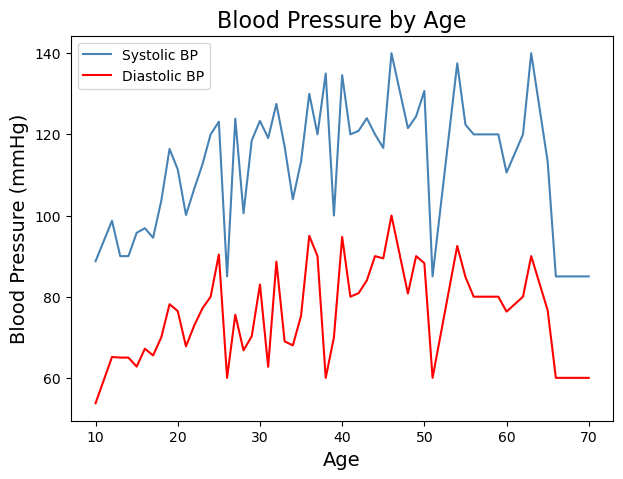

In [65]:
# Generate a line plot for BP
grouped_bp = maternal_df.groupby('Age')[['Systolic Blood Pressure', 'Diastolic Blood Pressure']].mean()

# Plotting data
plt.figure(figsize=(7, 5))
plt.plot(grouped_bp['Systolic Blood Pressure'], linestyle='-', color='steelblue', label='Systolic BP')
plt.plot(grouped_bp['Diastolic Blood Pressure'], linestyle='-', color='red', label='Diastolic BP')

# Labeling 
plt.xlabel('Age', fontsize=14)
plt.ylabel('Blood Pressure (mmHg)', fontsize=14)
plt.title('Blood Pressure by Age', fontsize=16)
plt.legend()

# Print
plt.show()